# Final Project

### Title: Multi Class Classification Of MRI Brain Scan Between Cognitively Normal, Alzheimer's Disease, Early Mild Cognitive Impairment &  Late Mild Cognitive Impairment Using CNNs

#### Task: Multi Class Image Classification

#### Dataset: ADNI-4C: Alzheimer's MRI Classification Dataset 
Dataset Link: https://www.kaggle.com/datasets/abdullahtauseef2003/adni-4c-alzheimers-mri-classification-dataset/data

#### Final Accuracy: 

By: Siddhant Chaudhary & Syed Fareed Hashim Ghouse


# EDA
This dataset consists of MRI brain scans categorized into four classes for Alzheimer's Disease classification:

1) Alzheimer's Disease (AD): 8960 images
2) Cognitively Normal (CN): 6464 images
3) Early Mild Cognitive Impairment (EMCI): 9600 images
4) Late Mild Cognitive Impairment (LMCI): 8960 images

> Below are 2 sample images from each of our 4 classes. AD, CN, EMCI, LMCI

In [1]:
"""IMPORTS"""
import os
from IPython.display import Image as PyImage
from IPython.display import display
import pandas as pd
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical # For one-hot encoding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import random
SEED=42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


### Here are some sample images of the data we are working with:

8961 AD files found
6464 CN files found
9600 EMCI files found
8960 LMCI files found
Sample AD images


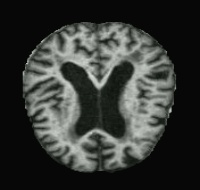

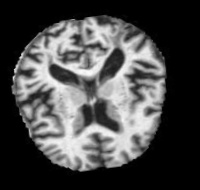

Sample CN images


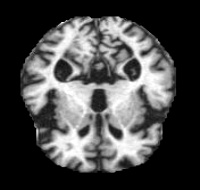

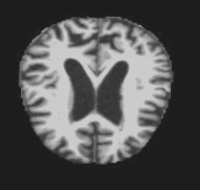

Sample EMCI images


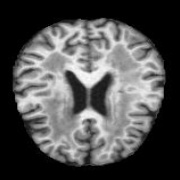

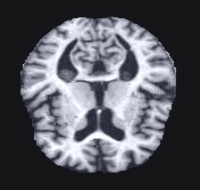

Sample LMCI images


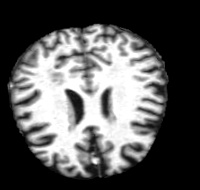

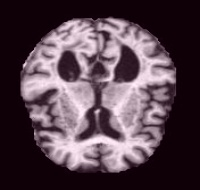

In [2]:
"""LOADING ALL FILES AND SHOWING SAMPLES"""

AD_files = []
CN_files = []
EMCI_files = []
LMCI_files = []

for type in ['AD', 'CN', 'EMCI', 'LMCI']:

    for root, dirs, files in os.walk(f"AugmentedAlzheimerDataset/{type}"):
        for file in files:
            if file.endswith(".jpg"):
                if type == 'AD':
                    AD_files.append(os.path.join(root, file))
                if type == 'CN':
                    CN_files.append(os.path.join(root, file))
                if type == 'EMCI':
                    EMCI_files.append(os.path.join(root, file))
                if type == 'LMCI':
                    LMCI_files.append(os.path.join(root, file))

print(len(AD_files), "AD files found")
print(len(CN_files), "CN files found")
print(len(EMCI_files), "EMCI files found")
print(len(LMCI_files), "LMCI files found")

print("Sample AD images")
for i in range(2):
    image_path = AD_files[i]
    #print(f"Displaying: {image_path}")
    display(PyImage(filename=image_path)) 

print("Sample CN images")
for i in range(2):
    image_path = CN_files[i]
    #print(f"Displaying: {image_path}")
    display(PyImage(filename=image_path))

print("Sample EMCI images")
for i in range(2):
    image_path = EMCI_files[i]
    #print(f"Displaying: {image_path}")
    display(PyImage(filename=image_path))

print("Sample LMCI images")
for i in range(2):
    image_path = LMCI_files[i]
    #print(f"Displaying: {image_path}")
    display(PyImage(filename=image_path))


    

In the eda below we can see the following things.

1. All images are in the color mode RGB. 
2. There is a slight imbalance in quantity (The CN class has the least number of images, in a real-world application however this would be quite different since most cases will be cognitively normal. Or maybe not, I am not a doctor.) But since our goal for this project is to make predictions for this dataset this is okay.
3. Most images (14464) are 200 by 190 pixels.
4. Some images (960) are 180 by 180 pixels.  


## What to do about this information?

1. I think the color-mode has been set arbitrarily to RGB when in reality it should be Grayscale since MRI scans are not capable of color-imaging. This is why we will make this change ourselves before proceeding.

2. The Image size also varies a little, but this will not be a problem since in the preprocessing step we will downsample all images to 32X32. This will maintain homogeneity

mode
RGB    33984
L          1
Name: count, dtype: int64
type
EMCI    9600
AD      8961
LMCI    8960
CN      6464
Name: count, dtype: int64
width
200    27585
180     6400
Name: count, dtype: int64
height
190    27585
180     6400
Name: count, dtype: int64


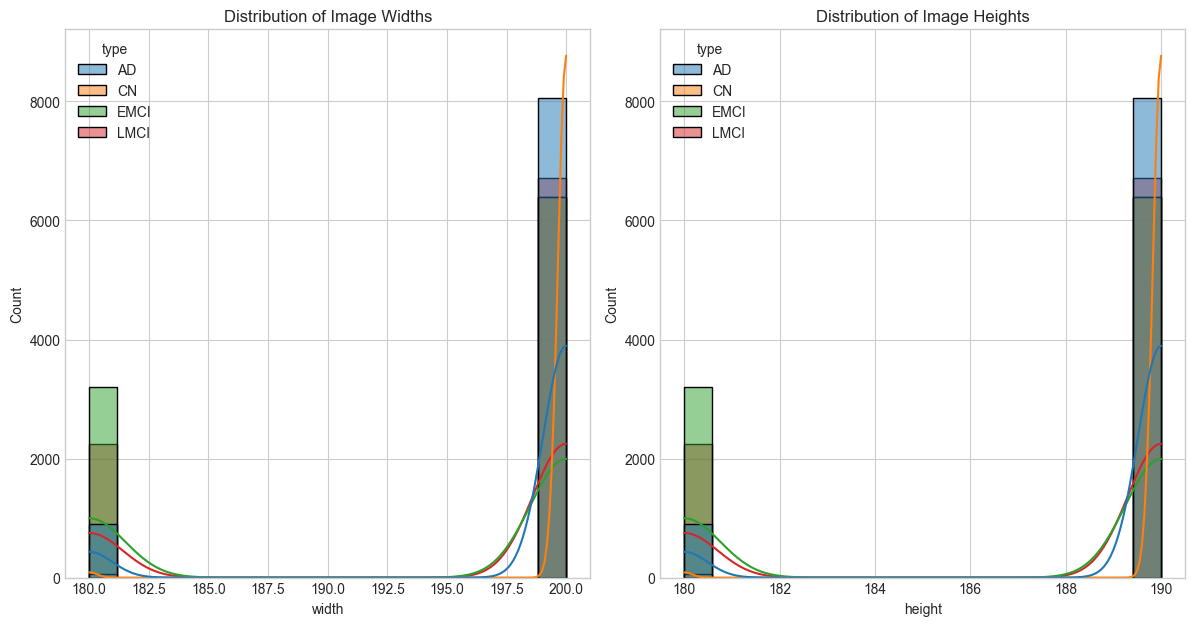

In [3]:
"""FETCHING IMAGE DATA FOR EACH IMAGE FOR PREPROCESSING & EDA"""
def get_image_info(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        mode = img.mode
        return width, height, mode
    
all_image_data = []

if "all_image_data.json" in os.listdir('.'):
    with open('all_image_data.json', 'r') as f:
        all_image_data = json.load(f)
else:
    for image_path in AD_files:
        width, height, mode = get_image_info(image_path)
        all_image_data.append({'path': image_path, 'type': 'AD', 'width': width, 'height': height, 'mode': mode})

    for image_path in CN_files:
        width, height, mode = get_image_info(image_path)
        all_image_data.append({'path': image_path, 'type': 'CN', 'width': width, 'height': height, 'mode': mode})

    for image_path in EMCI_files:
        width, height, mode = get_image_info(image_path)
        all_image_data.append({'path': image_path, 'type': 'EMCI', 'width': width, 'height': height, 'mode': mode})

    for image_path in LMCI_files:
        width, height, mode = get_image_info(image_path)
        all_image_data.append({'path': image_path, 'type': 'LMCI', 'width': width, 'height': height, 'mode': mode})

    json.dump(all_image_data, open('all_image_data.json', 'w'), indent=4)


df = pd.DataFrame(all_image_data)

print(df['mode'].value_counts())
print(df['type'].value_counts())
print(df['width'].value_counts())
print(df['height'].value_counts())

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.histplot(data=df, x='width', hue='type', kde=True)
plt.title('Distribution of Image Widths')

plt.subplot(2, 3, 2)
sns.histplot(data=df, x='height', hue='type', kde=True)
plt.title('Distribution of Image Heights')

plt.tight_layout()
plt.show()

# Preproccessing

1. First we convert all images to grayscale. This saves memory (Since we basically drop the extra color columns.) & will speed up proccessing. It also logically makes sense since MRI scans cannot make color images.
2. We now apply gaussian blur (optional) to all images to minimize noise from the MRI scan.
3. We now crop each image (Optional) (Like in the extra credit assignment) so that the edges of the MRI scan are touching the borders. This reduces noise & useless data in each picture. Probably this will allow the model to learn better.
4. We will now apply histogram equalization (Optional) to improve the contrast of the images. This will hopefully allow for better classification.
5. We then convert our images into a standard square dimension. We need to make it a square dimension because this will allow for simplicity when training our CNN since most CNN arcitectures are defaulted to expect a square image. We could have just dropped the 960 images and kept the 200X190 pixel images but this would lead to abandoning perfectly good data. We instead went with resizing using the LANCZOS downsampling filter.
6. We then convert every image to an array
7. We then normalize this array data using z-score normalization. 
8. We also add a channel dimension into the array since this is the format most CNN libraries expect even if image is grayscale.

We chose to heavily downsample our images all the way down to 32X32 as our target size since this would allow us to be as effecient as possible with training our model, feature engineering & evaluating. Our biggest constraint is compute with this project, and so we thought it would be nice to use other techniques like feature engineering instead of relying on high quality data which needs much more compute.

# Feature Engineering
This information has been mentioned in the above preprocessing section, But we mention it again to highligh these steps seperately, since these are the steps we activate or deactivate below in the different code cells.

1. Cropping (We crop the image to only contain the brain and drop useless confounding information)
2. Normalization (Applying Z-score normalization is better than min-max since MRI intensities can vary significantly between scans due to different machines or settings.)
3. Gaussian Blur (To remove noise that may occur during a MRI scan so that the CNN may focus on larger more important aspects of the image rather than noise. Apparently a noise-reduction blur like this is common practice when working with MRI scans)
4. Histogram Equalization. (This allows us to create some extra contrast in the image allowing the CNN to more easily capture changes in brain-matter)

Sample cropped AD images


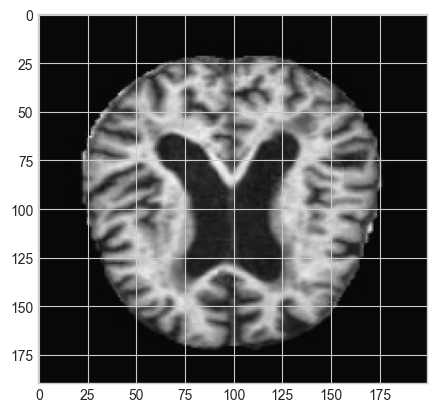

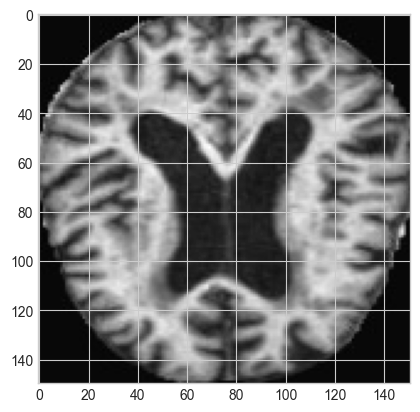

In [4]:
"""EXAMPLE OF THE CROP FUNCTION"""
"""Slightly different than how I did it in the extra credit because manual thresholding was just not working for some reason."""
def crop(img):
    # Convert to grayscale if necessary
    if len(img.shape) == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img

    # Apply a threshold to create a binary mask.
    # Otsu's method automatically finds a good threshold. I had to look this up because my manual thresholding was not working.
    ret, thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    # Find the largest contour (assuming it's the brain)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box coordinates of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the original image using the bounding box coordinates
    cropped_img = img[y:y+h, x:x+w]

    return cropped_img

print("Sample cropped AD images")

image_path = AD_files[0]
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.show()
cropped_img = crop(img)
plt.imshow(cropped_img, cmap='gray')
plt.show()

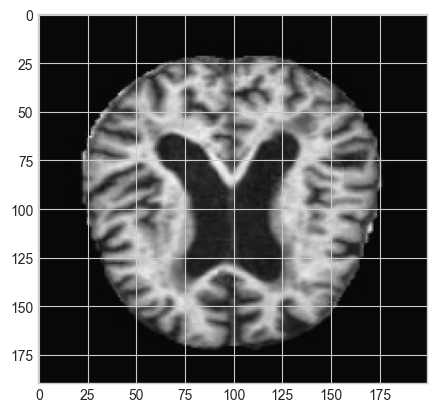

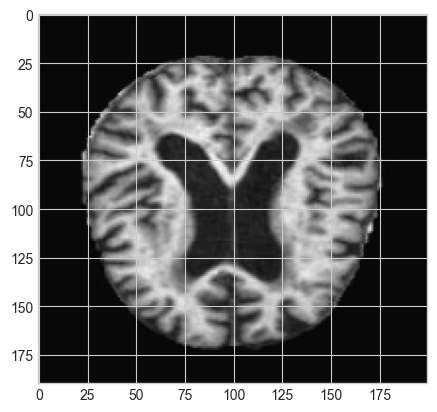

In [5]:
"""EXAMPLE OF THE GAUSSIAN BLUR FUNCTION"""
def gaussian_blur(image, GAUSSIAN_BLUR_RADIUS):
    blurred_img = ImageFilter.GaussianBlur(radius=GAUSSIAN_BLUR_RADIUS)
    blurred_img = image.filter(blurred_img)
    return blurred_img


image_path = AD_files[0]
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.show()
img = Image.fromarray(img)
blurred_img = gaussian_blur(img, GAUSSIAN_BLUR_RADIUS=0.25)
plt.imshow(blurred_img, cmap='gray')
plt.show()

In [6]:
"""MAIN PREPROCESSING FUNCTION"""
def preprocess_images_flexible(
    AD_files, CN_files, EMCI_files, LMCI_files,

    CROP_IMAGE=True,
    APPLY_HIST_EQUALIZATION=True, # Flag for Histogram Equalization
    APPLY_GAUSSIAN_BLUR=True,    # Flag for Gaussian Blur (Noise Reduction)
    ZSCORE_NORMALIZATION=True,    # Flag for Z-score Normalization

    TARGET_SIZE=(32, 32),
    GAUSSIAN_BLUR_RADIUS=0.25        # Radius for Gaussian Blur if applied
):

    CN_arrays = []
    AD_arrays = []
    EMCI_arrays = []
    LMCI_arrays = []

    epsilon = 1e-6 # For Z-score normalization stability
    count = 0
    for list_of_files in [AD_files, CN_files, EMCI_files, LMCI_files]:
        for file_path in list_of_files:

            with Image.open(file_path) as img:
                grayscale_img = img.convert('L')
                img_to_process = grayscale_img # Start with grayscale

                # --- Gaussian Blur (Noise Reduction) ---
                if APPLY_GAUSSIAN_BLUR:
                    img_to_process = gaussian_blur(img_to_process, GAUSSIAN_BLUR_RADIUS)
                
                processed_pil_img = None # PIL image after cropping

                # --- Optional Cropping ---
                if CROP_IMAGE:
                    img_array_original = np.array(img_to_process)
                    cropped_array = crop(img_array_original)
                    processed_pil_img = Image.fromarray(cropped_array)

                else:
                    processed_pil_img = img_to_process # Use potentially blurred image directly

                # --- Optional Histogram Equalization ---
                if APPLY_HIST_EQUALIZATION:
                    img_to_resize = ImageOps.equalize(processed_pil_img)
                else:
                    img_to_resize = processed_pil_img 

                # --- Resize ---
                resized_img = img_to_resize.resize(TARGET_SIZE, Image.Resampling.LANCZOS)
                final_processed_array_2d = np.array(resized_img) # 2D array

                # --- Z-score Normalization (Standard) ---
                if ZSCORE_NORMALIZATION:
                    image_float = final_processed_array_2d.astype(np.float32)
                    mean = np.mean(image_float)
                    std_dev = np.std(image_float)
                    normalized_img = (image_float - mean) / (std_dev + epsilon)
                else:
                    # Min-Max Normalization
                    min_val = np.min(final_processed_array_2d)
                    max_val = np.max(final_processed_array_2d)
                    normalized_img = (final_processed_array_2d - min_val) / (max_val - min_val + epsilon)

                # --- Add Channel Dimension ---
                expanded_img_3d = np.expand_dims(normalized_img, axis=-1) # Shape (H, W, 1)

                # Append the processed image array
                if 'AD' in file_path:
                    AD_arrays.append(expanded_img_3d)
                elif 'CN' in file_path:
                    CN_arrays.append(expanded_img_3d)
                elif 'EMCI' in file_path:
                    EMCI_arrays.append(expanded_img_3d)
                elif 'LMCI' in file_path:
                    LMCI_arrays.append(expanded_img_3d)

            count+=1
            if count % 10000 == 0:
                print(f"Processed {count} images...")
                
    # Return only the lists of image arrays
    return CN_arrays, AD_arrays, EMCI_arrays, LMCI_arrays

# Splitting the data

Now before we begin training we have to split the dataset into a Train Set, a Validation Set & a Testing Set. To do this we first add all the arrays together (CN_array, LMCI_array, AD_array & EMCI_array) and then apply train_test_split on them (random_state = 42 as described in the imports cell on the top as our global SEED.)

We also need to label these images, to do that we just assign an arbitrary number to each class (0,1,2,3).

In [7]:
""" RUNNING DATA SPLITTING & CNN MODEL CREATION """

def split_data(CN_arrays, AD_arrays, EMCI_arrays, LMCI_arrays, NUM_CLASSES=4,SEED=42):

    X_list = CN_arrays + AD_arrays + EMCI_arrays + LMCI_arrays

    y_integer_list = [0] * len(CN_arrays) + \
                    [1] * len(AD_arrays) + \
                    [2] * len(EMCI_arrays) + \
                    [3] * len(LMCI_arrays)

    # Convert lists to NumPy arrays
    X = np.array(X_list)
    y_integer = np.array(y_integer_list)

    y = to_categorical(y_integer, num_classes=NUM_CLASSES)


    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=SEED) 

    # separate train and validation from the remaining 80%
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=SEED)

    return X_train, X_val, X_test, y_train, y_val, y_test


# Training CNN

To classify the images we are using a CNN. We make the neural net using the tensorflow library. The neural net has many hyperparameters which we will tune later. The arcitecture is the following:

Input layer -> Conv2D -> MaxPool2D -> Conv2D -> MaxPool2D -> Conv2D -> MaxPool2D -> Flatten -> Dropout -> Dense (Relu) -> Dense (SoftMax)

We run this at:

Batch Size: 32

Learning Rate: 0.001 (Default for Adam)

Dropout Rate: 0.5

Epochs: 25

In [ ]:
"""MAIN CNN MODEL TRAINING FUNCTION"""
def train_model(X_train, y_train, X_val, y_val, NUM_CLASSES=4, TARGET_SIZE=(32, 32), BATCH_SIZE=32, EPOCHS=25,LR = 0.001, DROPOUT_RATE=0.5, SEED=42):

    INPUT_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 1)

    model = keras.Sequential(
        [
            keras.Input(shape=INPUT_SHAPE),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(DROPOUT_RATE),
            layers.Dense(256, activation="relu"),
            layers.Dense(NUM_CLASSES, activation="softmax"), 
        ]
    )

    custom_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(loss="categorical_crossentropy", 
                optimizer=custom_optimizer,
                metrics=["accuracy"])

    history = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        verbose=0,
        shuffle=True,
    )
    print("Training finished.")

    return model, history

# Evaluating CNN

To evaluate the CNN:

1. We plot the Confusion Matrix heatmap using Seaborn
2. Print the test set accuracy
3. Plot the accuracy curves for the validation & train-set (training history)

In [9]:
"""MAIN CNN MODEL EVALUTATION FUNCTION"""
def evaluate_model(model, history, CLASS_NAMES, X_test, y_test):

    print("\nEvaluating model on test set...")
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {score[0]:.4f}")
    print(f"Test accuracy: {score[1]:.4f}")


    print("\nGenerating predictions on test set...")
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_test_integer = np.argmax(y_test, axis=1)


    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_integer, y_pred)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES)
    plt.title("Confusion Matrix")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print("\n Model Training History:")
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    return None


# Running Execution Code Without Any Feature Engineering

The current preprocessing steps are (No Feature Engineering Right Now):
1. Convert image to grayscale
2. Downsample image to 32X32
3. Normalize image array using min-max scaling

Processed 10000 images...
Processed 20000 images...
Processed 30000 images...
Training finished.

Evaluating model on test set...
Test loss: 0.3260
Test accuracy: 0.8705

Generating predictions on test set...
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Confusion Matrix:


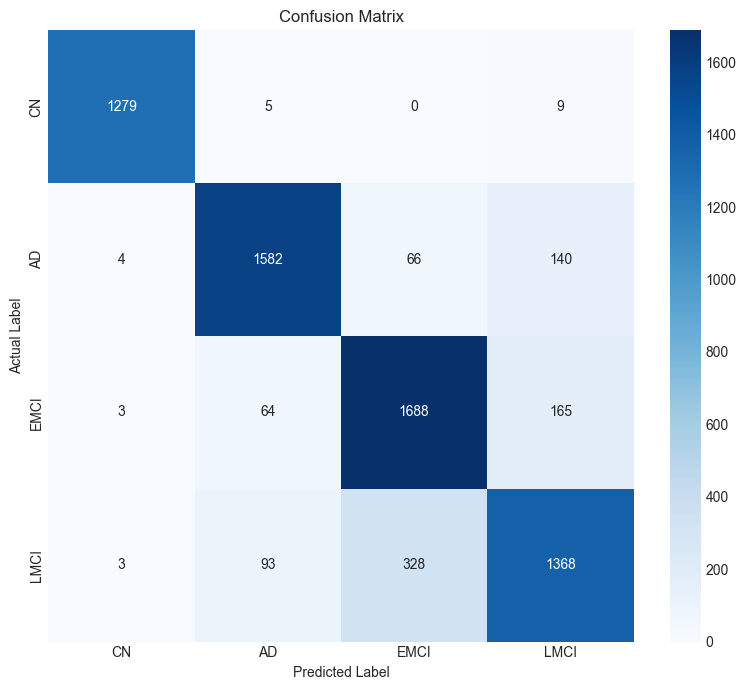


 Model Training History:


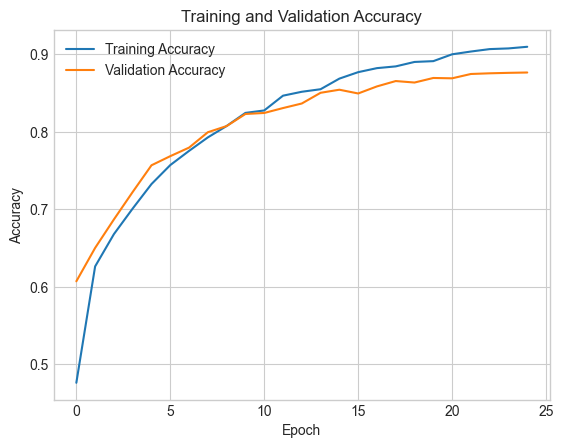

In [10]:
"""EXECUTING THE PREPROCESSING, TRAINING, AND EVALUATION"""

TARGET_SIZE = (32, 32) 
CROP_IMAGE = False 
APPLY_HIST_EQUALIZATION = False
APPLY_GAUSSIAN_BLUR = False
ZSCORE_NORMALIZATION = False
GAUSSIAN_BLUR_RADIUS = 0.1
NUM_CLASSES = 4
BATCH_SIZE = 32
EPOCHS = 25
LR = 0.001
DROPOUT_RATE = 0.5

CLASS_NAMES = ['CN', 'AD', 'EMCI', 'LMCI']


CN_arrays, AD_arrays, EMCI_arrays, LMCI_arrays = preprocess_images_flexible(AD_files, CN_files, EMCI_files, LMCI_files,
                                                                             CROP_IMAGE=CROP_IMAGE, APPLY_HIST_EQUALIZATION=APPLY_HIST_EQUALIZATION, APPLY_GAUSSIAN_BLUR=APPLY_GAUSSIAN_BLUR,ZSCORE_NORMALIZATION=ZSCORE_NORMALIZATION,
                                                                               TARGET_SIZE=TARGET_SIZE, GAUSSIAN_BLUR_RADIUS=GAUSSIAN_BLUR_RADIUS)

X_train, X_val, X_test, y_train, y_val, y_test = split_data(CN_arrays, AD_arrays, EMCI_arrays, LMCI_arrays, NUM_CLASSES=NUM_CLASSES, SEED=SEED)

model, history = train_model(X_train, y_train, X_val, y_val, NUM_CLASSES=NUM_CLASSES, TARGET_SIZE=TARGET_SIZE, BATCH_SIZE=BATCH_SIZE, EPOCHS=EPOCHS, LR=LR, DROPOUT_RATE=DROPOUT_RATE, SEED=SEED)

evaluate_model(model, history, CLASS_NAMES, X_test, y_test)



#### Test Accuracy of the CNN with Feature Engineering OFF is better than random sampling | 25.00% -> 87.05%

1. It is interesting to note here that the confusion matrix reveals the largest misclassifications happen when the model confuses EMCI & LMCI.
2. Other than that, the model seems to work & genralize well with both validation & training sets converging. However the validation set does have slightly lower accuracy. Maybe the feature engineering will help with this.

# Running Execution Code With Feature Engineering

Current preprocessing steps with feature engienering:

1. Convert image to grayscale
2. Apply gaussian blur
3. Crop image to remove empty space
4. Apply histogram equalization
5. Downsample the image to 32X32
6. Use Z-Score normalization (So incase different MRI machines were used, we scale using the standard-deviation of the scan.)

Processed 10000 images...
Processed 20000 images...
Processed 30000 images...
Training finished.

Evaluating model on test set...
Test loss: 0.1353
Test accuracy: 0.9489

Generating predictions on test set...
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Confusion Matrix:


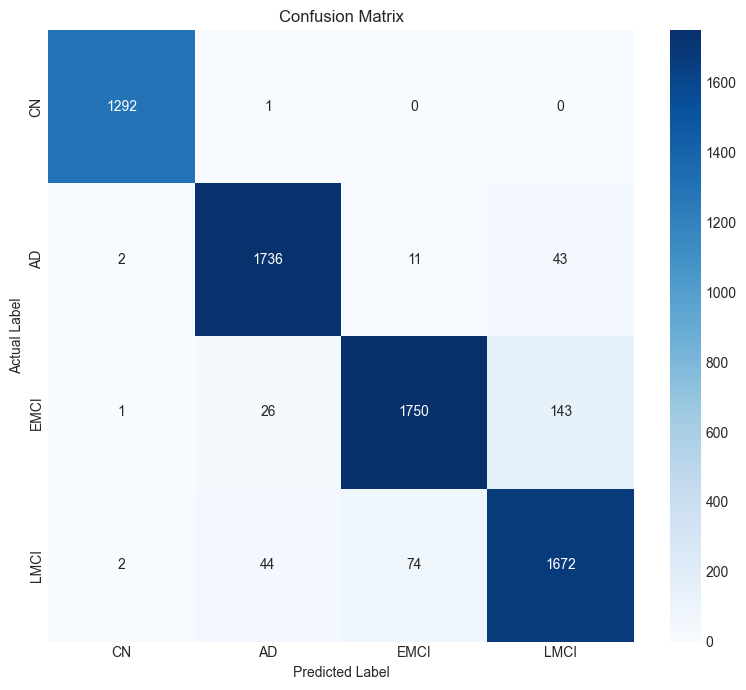


 Model Training History:


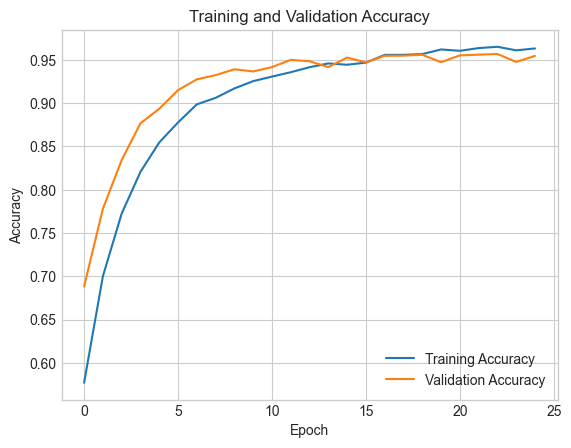

In [11]:
"""EXECUTING THE PREPROCESSING, TRAINING, AND EVALUATION (WITH FEATURE ENGINEERING IN THE PREPROCESSING FUNCTION)"""

TARGET_SIZE = (32, 32) 
CROP_IMAGE = True 
APPLY_HIST_EQUALIZATION =True
APPLY_GAUSSIAN_BLUR = True
ZSCORE_NORMALIZATION = True
GAUSSIAN_BLUR_RADIUS = 0.25
NUM_CLASSES = 4
BATCH_SIZE = 32
EPOCHS = 25
LR = 0.001
DROPOUT_RATE = 0.5

CLASS_NAMES = ['CN', 'AD', 'EMCI', 'LMCI']

CN_arrays, AD_arrays, EMCI_arrays, LMCI_arrays = preprocess_images_flexible(AD_files, CN_files, EMCI_files, LMCI_files, 
                                                                            CROP_IMAGE=CROP_IMAGE, APPLY_HIST_EQUALIZATION=APPLY_HIST_EQUALIZATION, APPLY_GAUSSIAN_BLUR=APPLY_GAUSSIAN_BLUR,ZSCORE_NORMALIZATION=ZSCORE_NORMALIZATION,
                                                                            GAUSSIAN_BLUR_RADIUS=GAUSSIAN_BLUR_RADIUS, TARGET_SIZE=TARGET_SIZE)

X_train, X_val, X_test, y_train, y_val, y_test = split_data(CN_arrays, AD_arrays, EMCI_arrays, LMCI_arrays, NUM_CLASSES=NUM_CLASSES, SEED=SEED)


model, history = train_model(X_train, y_train, X_val, y_val, NUM_CLASSES=NUM_CLASSES, TARGET_SIZE=TARGET_SIZE, BATCH_SIZE=BATCH_SIZE, EPOCHS=EPOCHS, LR=LR, DROPOUT_RATE=DROPOUT_RATE, SEED=SEED)

evaluate_model(model, history, CLASS_NAMES, X_test, y_test)



### With Feature Engineering On | Test Accuracy increased from 87.05 -> 94.89%

We can now see performance is significantly better.

1. The most commonly confused classes are still LMCI & EMCI
2. However the validation and training accuracy is much closer now and while the growth tapers off, the accuracy continues to increase till the very last epoch.

# Creating an Ensemble

It becomes clear that the model is most often wrong in classifying between LMCI & EMCI. To improve on this we will create 2 models more (both CNN) which will be One-Vs-All classifiers. 

Ensemble classifiers:
1. EMCI vs All
2. LMCI vs All

We will then pass the entire training set & test set to 3 models.
1. Main 4-Class classifier
2. EMCI vs All
3. LMCI vs All

We will then calculate the weighted average of the probability for the EMCI & LMCI classes from their respected expert model's predictions with our main 4-class classifier.

# Splitting data for ensemble

We will now need make it so that y is either EMCI - or - Not-EMCI. We will have to rewrite the data splitting function to do that.

In [12]:
"""SPLITTING DATA FOR ONE-VS-ALL (OvA) CLASSIFICATION"""
def split_data_one_vs_all(X_all, y_all_integer, target_class_index, SEED=42):

    # Create binary labels: 1 for target class, 0 for all others
    y_binary = np.where(y_all_integer == target_class_index, 1, 0)

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_all, y_binary,
        test_size=0.20,
        stratify=y_binary,
        random_state=SEED
    )

    # Split train+validation into train (60% of total) and validation (20% of total)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=0.25,
        stratify=y_train_val,
        random_state=SEED
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test


# Training OVA models

We will use a very similar CNN arcitecture for the OVA models

Input -> Conv2D -> MaxPool2D -> Conv2D -> MaxPool2D -> Conv2D -> MaxPool2D -> Flatten -> Dropout -> Dense(Relu) -> Dense(sigmoid)

We run this at:

Batch Size: 32

Learning Rate: 0.001 (Default for Adam)

Dropout Rate: 0.5

Epochs: 25

In [13]:
"""FUNCTION FOR TRAINING BINARY OvA MODEL"""

def train_binary_ova_model(X_train, y_train, X_val, y_val, BATCH_SIZE=32, EPOCHS=25, class_index=None):

    INPUT_SHAPE = X_train.shape[1:]
    NUM_CLASSES = 1 # Single output for sigmoid

    model = keras.Sequential(
        [
            keras.Input(shape=INPUT_SHAPE),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(256, activation="relu"),
            # Final layer for BINARY classification (1 output unit, sigmoid activation)
            layers.Dense(NUM_CLASSES, activation="sigmoid"),
        ]
    )

    # --- Compile Model ---
    model.compile(loss="binary_crossentropy", # Use binary_crossentropy for 0/1 labels
                  optimizer="adam",
                  metrics=["accuracy"])

    # --- Train Model ---
    print(f"\nStarting BINARY OvA model training (Class {class_index} vs Rest)...")
    history = model.fit(
        X_train,
        y_train, # Pass integer labels (0 or 1)
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        verbose=0,
        shuffle=True,
    )
    print(f"Binary OvA (Class {class_index}) training finished.")

    return model, history


# Ensembling the results from main model with OVA models

1. we generate 3 sets of predicted probabilities: 
    > p_emci_vs_all (N,1)

    > p_lmci_vs_all (N,1)

    > pred_prob_main (N,4)

2. Now to ensemble these probabilities, we simply replace the probabilities in the main predicted probabilities array (N,4) with a weighted ensemble for that class
    > (w_main * y_pred_prob_main[:, EMCI_INDEX]) + (w_ova * p_emci_vs_all[:, 0])

3. Finally we can now renormalize the probabilities so it all adds up to 1

4. Finally to evaluate the model we plot the confusion matrix, the accuracy history (for validation & training sets) for all 3 models & the final ensembled accuracy.

In [14]:
""" FUNCTION FOR EVALUATING ENSEMBLED CLASSIFIERS """
def evaluate_with_ova_classifiers_weighted(main_model,main_history, emci_ova_model,emci_ova_history, lmci_ova_model,lmci_ova_history,
                                         X_test, y_test, CLASS_NAMES,
                                         EMCI_INDEX=2, LMCI_INDEX=3,
                                         w_main=0.5, w_ova=0.5): 

    epsilon = 1e-9 # For safe division during normalization

    # --- Get Predictions ---
    print("Generating predictions from all models...")
    y_pred_prob_main = main_model.predict(X_test) # Shape (N, 4)
    p_emci_vs_all = emci_ova_model.predict(X_test) # Shape (N, 1) - Prob of being EMCI
    p_lmci_vs_all = lmci_ova_model.predict(X_test) # Shape (N, 1) - Prob of being LMCI

    # --- Ensemble Logic: Weighted Averaging & Renormalization ---
    y_pred_prob_ensembled = y_pred_prob_main.copy() # Start with main probabilities

    # Calculate weighted probabilities for EMCI and LMCI
    prob_emci_weighted = (w_main * y_pred_prob_main[:, EMCI_INDEX]) + (w_ova * p_emci_vs_all[:, 0])
    prob_lmci_weighted = (w_main * y_pred_prob_main[:, LMCI_INDEX]) + (w_ova * p_lmci_vs_all[:, 0])

    # Update the probabilities in the final array
    y_pred_prob_ensembled[:, EMCI_INDEX] = prob_emci_weighted
    y_pred_prob_ensembled[:, LMCI_INDEX] = prob_lmci_weighted

    # Re-normalize probabilities for each sample so they sum to 1
    row_sums = y_pred_prob_ensembled.sum(axis=1)
    y_pred_prob_final = y_pred_prob_ensembled / (row_sums[:, np.newaxis] + epsilon) # Add epsilon for stability

    # --- Final Decision ---
    y_pred_final_int = np.argmax(y_pred_prob_final, axis=1)

    # --- Evaluate Final Ensembled Predictions ---
    y_test_integer = np.argmax(y_test, axis=1)

    print("\n--- Evaluation Metrics After Weighted OvA Ensemble ---")
    final_accuracy = accuracy_score(y_test_integer, y_pred_final_int)
    print(f"Final Ensembled Test Accuracy: {final_accuracy:.4f}")


    print("\nEnsembled Confusion Matrix:")
    cm_final = confusion_matrix(y_test_integer, y_pred_final_int)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm_final, annot=True, fmt="d", cmap="Blues",
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES)
    plt.title("Ensembled Confusion Matrix (Weighted OvA)")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    print("\n--- Plotting Training and Validation Accuracy ---")
    plt.plot(main_history.history['accuracy'], label='Main Training Accuracy')
    plt.plot(main_history.history['val_accuracy'], label='Main Validation Accuracy')
    plt.title('Main Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print("\n--- Plotting OvA Training and Validation Accuracy ---")
    plt.plot(emci_ova_history.history['accuracy'], label='EMCI OvA Training Accuracy')
    plt.plot(emci_ova_history.history['val_accuracy'], label='EMCI OvA Validation Accuracy')
    plt.title('EMCI OvA Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print("\n--- Plotting LMCI OvA Training and Validation Accuracy ---")
    plt.plot(lmci_ova_history.history['accuracy'], label='LMCI OvA Training Accuracy')
    plt.plot(lmci_ova_history.history['val_accuracy'], label='LMCI OvA Validation Accuracy')
    plt.title('LMCI OvA Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


    return None




--- Running Preprocessing ---
Processed 10000 images...
Processed 20000 images...
Processed 30000 images...
Splitting Data for Main 4-Class Model
Training Main 4-Class Model
Training finished.
Training EMCI-vs-All Model

Starting BINARY OvA model training (Class 2 vs Rest)...
Binary OvA (Class 2) training finished.
Training LMCI-vs-All Model

Starting BINARY OvA model training (Class 3 vs Rest)...
Binary OvA (Class 3) training finished.
Generating predictions from all models...
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

--- Evaluation Metrics After Weighted OvA Ensemble ---
Final Ensembled Test Accuracy: 0.9844

Ensembled Confusion Matrix:


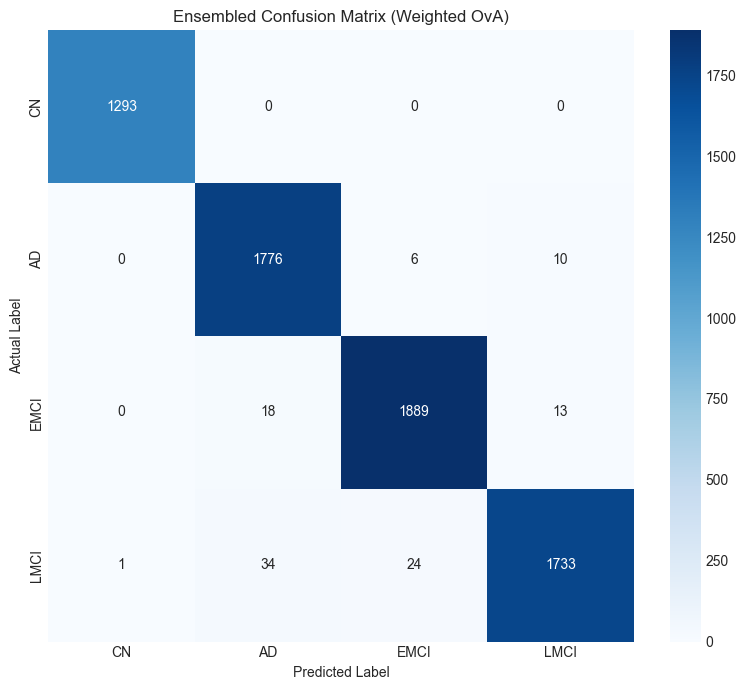


--- Plotting Training and Validation Accuracy ---


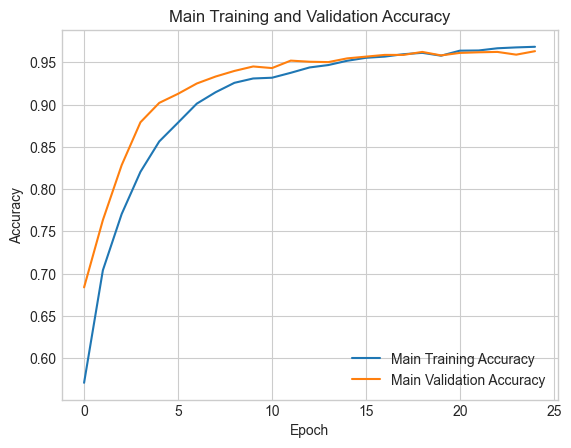


--- Plotting OvA Training and Validation Accuracy ---


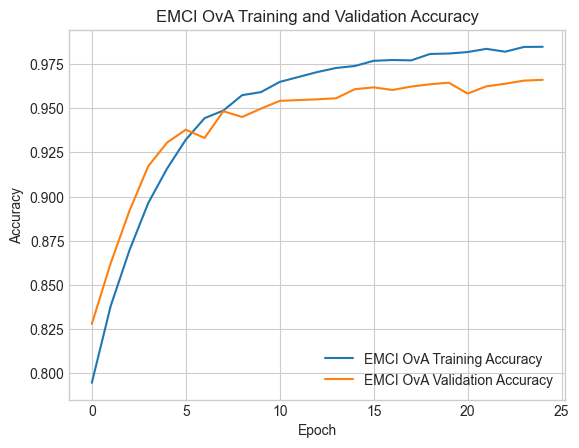


--- Plotting LMCI OvA Training and Validation Accuracy ---


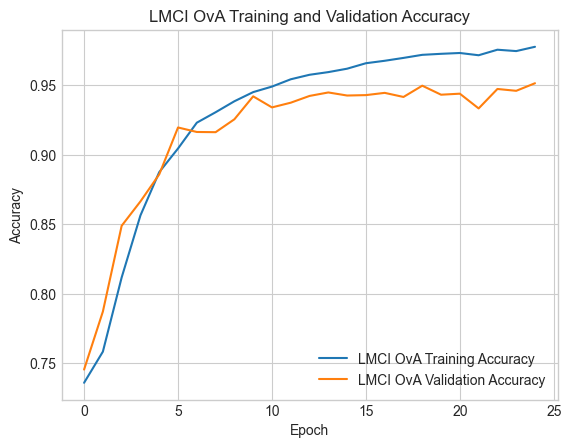

In [15]:
"""EXECUTING ENSEMBLED CLASSIFIER TRAINING AND EVALUATION"""

TARGET_SIZE = (32, 32)
CROP_IMAGE = True
APPLY_HIST_EQUALIZATION = True
APPLY_GAUSSIAN_BLUR = True
ZSCORE_NORMALIZATION = True
GAUSSIAN_BLUR_RADIUS = 0.25
NUM_CLASSES_MAIN = 4
BATCH_SIZE = 32
EPOCHS = 25

CLASS_NAMES = ['CN', 'AD', 'EMCI', 'LMCI']
EMCI_INDEX = CLASS_NAMES.index('EMCI') # Should be 2
LMCI_INDEX = CLASS_NAMES.index('LMCI') # Should be 3

print("--- Running Preprocessing ---")
CN_arrays, AD_arrays, EMCI_arrays, LMCI_arrays = preprocess_images_flexible(
                                                                            AD_files, CN_files, EMCI_files, LMCI_files,
                                                                            CROP_IMAGE=CROP_IMAGE,
                                                                            APPLY_HIST_EQUALIZATION=APPLY_HIST_EQUALIZATION,
                                                                            APPLY_GAUSSIAN_BLUR=APPLY_GAUSSIAN_BLUR,
                                                                            ZSCORE_NORMALIZATION=ZSCORE_NORMALIZATION,
                                                                            TARGET_SIZE=TARGET_SIZE,
                                                                            GAUSSIAN_BLUR_RADIUS=GAUSSIAN_BLUR_RADIUS,)


print("Splitting Data for Main 4-Class Model")
X_train_main, X_val_main, X_test_main, y_train_main, y_val_main, y_test_main = split_data(CN_arrays, AD_arrays, EMCI_arrays, LMCI_arrays, NUM_CLASSES=NUM_CLASSES, SEED=SEED)


print("Training Main 4-Class Model")
main_model, main_history = train_model( X_train_main, y_train_main, X_val_main, y_val_main,
                                        NUM_CLASSES=NUM_CLASSES_MAIN,
                                        TARGET_SIZE=TARGET_SIZE, # Pass if needed
                                        BATCH_SIZE=BATCH_SIZE,
                                        EPOCHS=EPOCHS,
                                        LR=LR,
                                        DROPOUT_RATE=DROPOUT_RATE,
                                        SEED=SEED
                                    )


# Split and Train EMCI-vs-All Model

X_all = np.array(CN_arrays + AD_arrays + EMCI_arrays + LMCI_arrays)
y_all_integer = np.array([0] * len(CN_arrays) +[1] * len(AD_arrays) +[2] * len(EMCI_arrays) +[3] * len(LMCI_arrays))

X_train_ova_emci, X_val_ova_emci, X_test_ova_emci, y_train_ova_emci, y_val_ova_emci, y_test_ova_emci = split_data_one_vs_all(
                                                                                                        X_all, y_all_integer, target_class_index=EMCI_INDEX, SEED=SEED)

print("Training EMCI-vs-All Model")
emci_ova_model, emci_ova_history = train_binary_ova_model(X_train_ova_emci, y_train_ova_emci,X_val_ova_emci, y_val_ova_emci,
                                                            BATCH_SIZE=BATCH_SIZE,
                                                            EPOCHS=EPOCHS,
                                                            class_index=EMCI_INDEX)


X_train_ova_lmci, X_val_ova_lmci, X_test_ova_lmci,y_train_ova_lmci, y_val_ova_lmci, y_test_ova_lmci = split_data_one_vs_all(
                                                                                                        X_all, y_all_integer, target_class_index=LMCI_INDEX, SEED=SEED)

print("Training LMCI-vs-All Model")
lmci_ova_model, lmci_ova_history = train_binary_ova_model(X_train_ova_lmci, y_train_ova_lmci, X_val_ova_lmci, y_val_ova_lmci,
                                                                BATCH_SIZE=BATCH_SIZE,
                                                                EPOCHS=EPOCHS,
                                                                class_index=LMCI_INDEX)



evaluate_with_ova_classifiers_weighted(main_model,main_history,emci_ova_model,emci_ova_history,lmci_ova_model,lmci_ova_history,
                                        X_test_main, y_test_main, CLASS_NAMES,
                                        EMCI_INDEX=EMCI_INDEX,LMCI_INDEX=LMCI_INDEX,
                                        w_main=0.2, w_ova=0.8 )

### Ensembeled Model | Accuracy increased from 94.89% -> 98.44%

This also resulted in a significant increase in accuracy and the most often confused classes are now no longer EMCI & LMCI

# Hyperparameter Tuning & Target Size Increase

From the graph it becomes aparent that the model may benefit from extra epochs. (Both validation & training accuracy rise till the last epoch, although very slowly)

It would also be interesting to see how the model benefits from a lower dropout rate, since the validation & training curve are pretty close across the entire training proccess (we dont seem to be overfitting too much.)

It would also be interesting to lower the learning rate a little to see what happens. This is because the rate of accuracy increase significantly slows down.

While this will be at the cost of higher computational costs, It will be interesting to increase the image resolution a little and see how that affects the accuracy of the model. This will likely lead to a higher accuracy. So In one final push we will now make all these changes and get our final model predictions.

--- Running Preprocessing ---
Processed 10000 images...
Processed 20000 images...
Processed 30000 images...
Splitting Data for Main 4-Class Model
Training Main 4-Class Model
Training finished.

Starting BINARY OvA model training (Class 2 vs Rest)...
Binary OvA (Class 2) training finished.

Starting BINARY OvA model training (Class 3 vs Rest)...
Binary OvA (Class 3) training finished.
Generating predictions from all models...
213/213 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step

--- Evaluation Metrics After Weighted OvA Ensemble ---
Final Ensembled Test Accuracy: 0.9848

Ensembled Confusion Matrix:


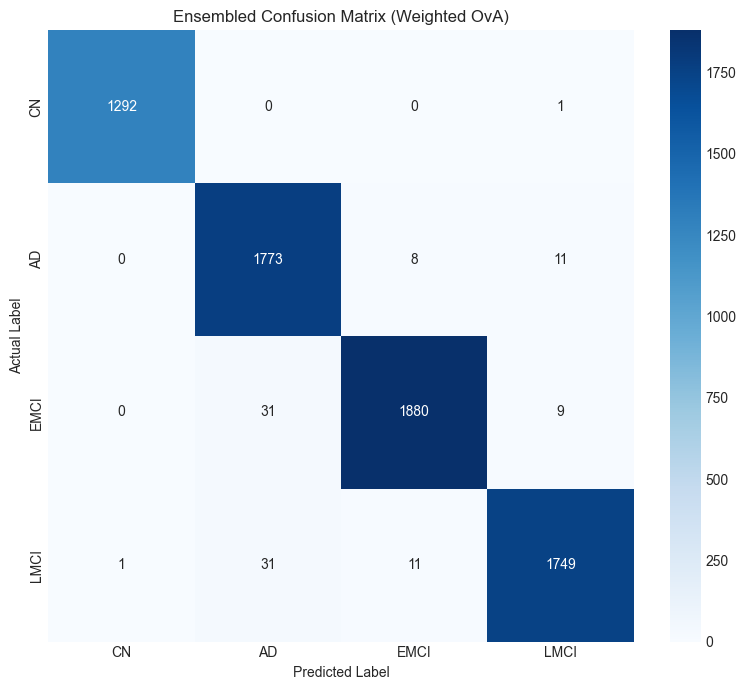


--- Plotting Training and Validation Accuracy ---


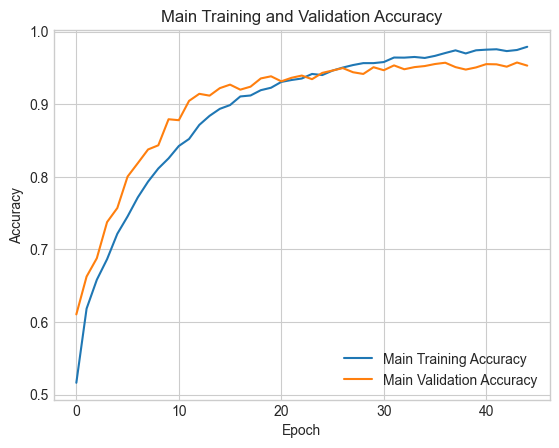


--- Plotting OvA Training and Validation Accuracy ---


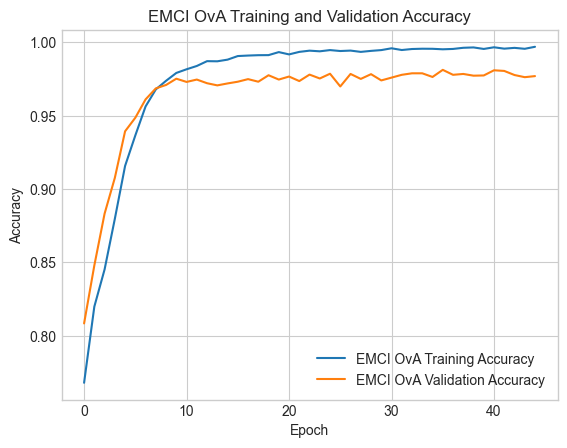


--- Plotting LMCI OvA Training and Validation Accuracy ---


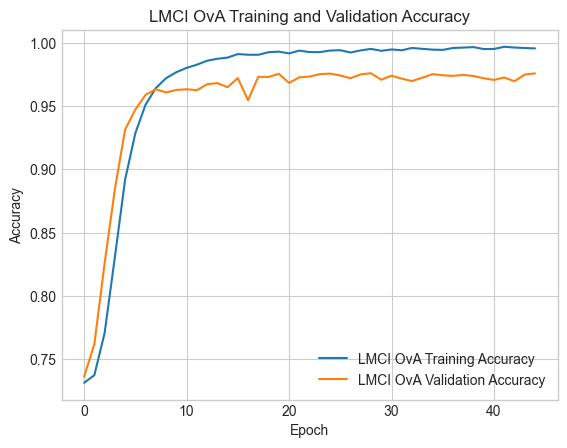

In [16]:
"""HYPERPARAMETER TUNING FOR MAIN MODEL & HIGHER RESOLUTION RESIZING - FINAL ENSEMBLED MODEL EXECUTION """

TARGET_SIZE = (128, 128) # INCREASED FROM 32X32 TO 128X128 FOR BETTER RESOLUTION
CROP_IMAGE = True
APPLY_HIST_EQUALIZATION = True
APPLY_GAUSSIAN_BLUR = True
ZSCORE_NORMALIZATION = True
GAUSSIAN_BLUR_RADIUS = 0.25
NUM_CLASSES_MAIN = 4
BATCH_SIZE = 64 # INCREASED FROM 32 TO 64 FOR FASTER TRAINING 
EPOCHS = 45 # INCREASED FROM 25 TO 45 FOR BETTER TRAINING
SEED = 42
LR = 0.005 # LOWERED FROM 0.001 TO 0.005 FOR BETTER TRAINING
DROPOUT_RATE = 0.4 # DROPOUT DECREASED FROM 0.5 TO 0.4 FOR BETTER TRAINING

CLASS_NAMES = ['CN', 'AD', 'EMCI', 'LMCI']
EMCI_INDEX = CLASS_NAMES.index('EMCI') # Should be 2
LMCI_INDEX = CLASS_NAMES.index('LMCI') # Should be 3

print("--- Running Preprocessing ---")
CN_arrays, AD_arrays, EMCI_arrays, LMCI_arrays = preprocess_images_flexible(AD_files, CN_files, EMCI_files, LMCI_files,
                                                                            CROP_IMAGE=CROP_IMAGE,
                                                                            APPLY_HIST_EQUALIZATION=APPLY_HIST_EQUALIZATION,
                                                                            APPLY_GAUSSIAN_BLUR=APPLY_GAUSSIAN_BLUR,
                                                                            ZSCORE_NORMALIZATION=ZSCORE_NORMALIZATION,
                                                                            TARGET_SIZE=TARGET_SIZE,
                                                                            GAUSSIAN_BLUR_RADIUS=GAUSSIAN_BLUR_RADIUS,
                                                                        )

print("Splitting Data for Main 4-Class Model")
X_train_main, X_val_main, X_test_main, y_train_main, y_val_main, y_test_main = split_data(CN_arrays, AD_arrays, EMCI_arrays, LMCI_arrays, NUM_CLASSES=NUM_CLASSES, SEED=SEED)

print("Training Main 4-Class Model")
main_model, main_history = train_model( X_train_main, y_train_main,X_val_main, y_val_main,
                                    NUM_CLASSES=NUM_CLASSES_MAIN,
                                    TARGET_SIZE=TARGET_SIZE, # Pass if needed
                                    BATCH_SIZE=BATCH_SIZE,
                                    EPOCHS=EPOCHS,
                                    LR=LR,
                                    DROPOUT_RATE=DROPOUT_RATE,
                                    SEED=SEED)


X_all = np.array(CN_arrays + AD_arrays + EMCI_arrays + LMCI_arrays)
y_all_integer = np.array([0] * len(CN_arrays) +[1] * len(AD_arrays) +[2] * len(EMCI_arrays) +[3] * len(LMCI_arrays))

X_train_ova_emci, X_val_ova_emci, X_test_ova_emci,y_train_ova_emci, y_val_ova_emci, y_test_ova_emci = split_data_one_vs_all(
                                                                                                        X_all, y_all_integer, target_class_index=EMCI_INDEX, SEED=SEED)


emci_ova_model, emci_ova_history = train_binary_ova_model(
                                    X_train_ova_emci, y_train_ova_emci,X_val_ova_emci, y_val_ova_emci,
                                    BATCH_SIZE=BATCH_SIZE,
                                    EPOCHS=EPOCHS,
                                    class_index=EMCI_INDEX)

X_train_ova_lmci, X_val_ova_lmci, X_test_ova_lmci,y_train_ova_lmci, y_val_ova_lmci, y_test_ova_lmci = split_data_one_vs_all(
                                                                                                        X_all, y_all_integer, target_class_index=LMCI_INDEX, SEED=SEED)

lmci_ova_model, lmci_ova_history = train_binary_ova_model(
                                    X_train_ova_lmci, y_train_ova_lmci,X_val_ova_lmci, y_val_ova_lmci,
                                    BATCH_SIZE=BATCH_SIZE,
                                    EPOCHS=EPOCHS,
                                    class_index=LMCI_INDEX)


evaluate_with_ova_classifiers_weighted(main_model,main_history,emci_ova_model,emci_ova_history,lmci_ova_model,lmci_ova_history,
                                        X_test_main, y_test_main, CLASS_NAMES,
                                        EMCI_INDEX=EMCI_INDEX,LMCI_INDEX=LMCI_INDEX,
                                        w_main=0.2,  w_ova=0.8 )

### Better Resolution + Tuned Hyperparameters + Ensembled Model | Accuracy increased from 98.44% -> 98.48% 

While not so significant this also resulted in an increase. Better hyperparameter tuning could have resulted in better results but running the model training with each image at 128X128 is incredibly computationaly intensive. (The last cell took nearly 3-hours to run.)